Light curves


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from astropy import table
import seaborn as sns
from astropy.io import fits

import lsst.alert.packet
from pathlib import Path
import matplotlib.pyplot as plt
import os
from copy import copy
import json
from collections import OrderedDict as odict


from astropy.table import Table, vstack
import timeit
import json
from astropy.io import fits
from astropy.time import Time
from fastavro import writer, reader
HOSTLIB_host=True
import shutil

In [7]:
scotch_path = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/SCOTCH10k/"
kn_path     = "/global/cscratch1/sd/kessler/SNANA_LSST_SIM/TMP_mlok_MLAG_SCOTCH10k_KN_K17_80D_NONIaMODEL0-0001_49191/"

In [3]:
def read_snana_fits(head_file, phot_file, snids=None, n=None):
    """Read the SNANA FITS format: two FITS files jointly representing
    metadata and photometry for a set of SNe.

    Parameters
    ----------
    head_file : str
        Filename of "HEAD" ("header") FITS file.
    phot_file : str
        Filename of "PHOT" ("photometry") FITS file.
    snids : list of str, optional
        If given, only return the single entry with the matching SNIDs.
    n : int
        If given, only return the first `n` entries.

    Returns
    -------
    sne : list of `~astropy.table.Table`
        Each item in the list is an astropy Table instance.

    Notes
    -----
    If `head_file` contains a column 'SNID' containing strings, leading and
    trailing whitespace is stripped from all the values in that column.

    If `phot_file` contains a column 'FLT', leading and trailing whitespace
    is stripped from all the values in that column.

    Examples
    --------
    >>> sne = read_snana_fits('HEAD.fits', 'PHOT.fits')
    >>> for sn in sne:
    ...     sn.meta  # Metadata in an OrderedDict.
    ...     sn['MJD']  # MJD column

    """

    # Should we memmap? Only if we're going to read only a part of the file
    memmap = (snids is not None or n is not None)

    # Get metadata for all the SNe
    head_data = fits.getdata(head_file, 1, view=np.ndarray)
    phot_data = fits.getdata(phot_file, 1, view=np.ndarray, memmap=memmap)

    # Strip trailing whitespace characters from SNID.
    if 'SNID' in head_data.dtype.names:
        try:
            head_data['SNID'][:] = np.char.strip(head_data['SNID'])
        except TypeError:
            pass

    # Check which indicies to return.
    if snids is None and n is None:
        idx = range(len(head_data))
    elif n is None:
        if 'SNID' not in head_data.dtype.names:
            raise RuntimeError('Specific snids requested, but head file does'
                               ' not contain SNID column')
        idx = []
        for snid in snids:
            i = np.flatnonzero(head_data['SNID'] == snid)
            if len(i) != 1:
                raise RuntimeError('Unique snid requested, but there are '
                                   '{0:d} matching entries'.format(len(i)))
            idx.append(i[0])
    elif snids is None:
        idx = range(n)
    else:
        raise ValueError("cannot specify both 'snids' and 'n' arguments")

    # Loop over SNe in HEAD file
    sne = []
    for i in idx:
        meta = odict(zip(head_data.dtype.names, head_data[i]))

        j0 = head_data['PTROBS_MIN'][i] - 1
        j1 = head_data['PTROBS_MAX'][i]
        data = phot_data[j0:j1]
        if 'BAND' in data.dtype.names:
            data['BAND'][:] = np.char.strip(data['BAND'])
        sne.append(Table(data, meta=meta, copy=False))

    return sne



In [34]:
# sne = read_snana_fits(scotch_path+ "MLAG_SCOTCH10k_KN_K17/MLAG_GP_SCOTCH10k_COPY_NONIaMODEL0-0001_HEAD.FITS.gz", scotch_path+ "MLAG_SCOTCH10k_KN_K17/MLAG_GP_SCOTCH10k_COPY_NONIaMODEL0-0001_PHOT.FITS.gz", n=200)
sne  = read_snana_fits(kn_path + "MLAG_GP_SCOTCH10k_K17_80D_NONIaMODEL0-0001_HEAD.FITS.gz", kn_path+"MLAG_GP_SCOTCH10k_K17_80D_NONIaMODEL0-0001_PHOT.FITS.gz")

In [35]:
len(sne)

300

In [32]:
n = 9
uband = sne[n][sne[n]['BAND']=='u']

(53150.0, 53250.0)

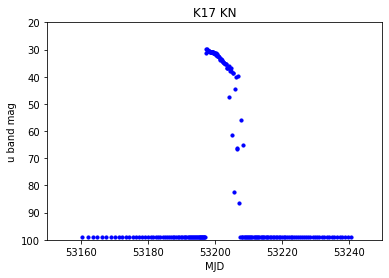

In [33]:
plt.scatter(uband['MJD'], uband['SIM_MAGOBS'], s=10, c='blue')
plt.ylim([100,20])
plt.ylabel("u band mag")
plt.xlabel("MJD")
plt.title("K17 KN")
plt.xlim([53150,53250])

In [60]:
len(uband)

101

In [20]:
# phot_data = fits.getdata(scotch_path + "MLAG_SCOTCH10k_KN_B19/MLAG_GP_SCOTCH10k_COPY_NONIaMODEL0-0001_PHOT.FITS.gz", 1, view=np.ndarray, memmap=True)
phot_data = fits.getdata(kn_path + "MLAG_GP_SCOTCH10k_K17_80D_NONIaMODEL0-0001_PHOT.FITS.gz", 1, view=np.ndarray, memmap=True)

In [21]:
mags = []
for phot in phot_data:
    # print(phot[1].astype(str))
    mags.append(phot[1].astype(str))
mags = np.asarray(mags)

In [22]:
us = np.where(mags=='u ')
gs = np.where(mags=='g ')

In [23]:
phot_data

array([(53160.502, b'u ', -5.2197522e-04,  4.4901602e-04, 99.      ),
       (53160.502, b'g ', -6.3252177e-05,  4.4962793e-04, 99.      ),
       (53160.502, b'r ', -1.8350013e-04,  4.5113143e-04, 99.      ), ...,
       (53240.663, b'z ',  4.0640436e-02,  2.4326164e-03, 31.00182 ),
       (53240.663, b'Y ',  5.1600054e-02,  2.6661390e-03, 30.781658),
       ( -777.   , b'- ', -7.7700000e+02, -7.7700000e+02, 99.      )],
      dtype=(numpy.record, [('MJD', '>f8'), ('BAND', 'S2'), ('FLUXCAL', '>f4'), ('FLUXCALERR', '>f4'), ('SIM_MAGOBS', '>f4')]))

In [24]:
umags = []
mjd   = []
gmags = []
for phot in phot_data[gs]:
    # umags.append(phot[4])
    mjd.append(phot[0])
    gmags.append(phot[4])

Text(0.5, 1.0, 'All K17')

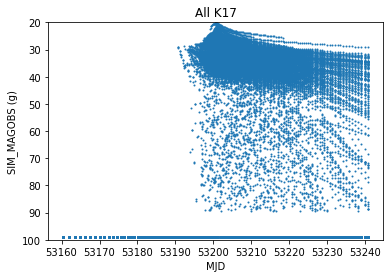

In [27]:
plt.scatter(mjd, gmags, s=1)
plt.xlabel("MJD")
plt.ylabel("SIM_MAGOBS (g)")
plt.ylim([100,20])
plt.title("All K17")

In [56]:
us

(array([], dtype=int64),)

In [54]:
mags[6]=='u '

True

In [28]:

kn['BAND'][:] = np.char.strip(kn['BAND'])

TypeError: string operation on non-string array

In [18]:
umags = []
for row in range(0,len(kn),6):
    kn['BAND']=='u'


b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'u '
b'- '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y '
b'Y 

KeyboardInterrupt: 